<a href="https://colab.research.google.com/github/a-woodbury/RxVision/blob/master/Notebooks/rxv_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Selection ( # Models)


# Environment Setup

## Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import imageio
import imgaug as ia

import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import os
import sys

import time
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
#from tensorflow import keras

import scipy
from PIL import Image
from scipy import ndimage

import multiprocessing

# from sklearn.datasets import make_classification
# from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix #, r2_score, recall_score, precision_score, f1_score, accuracy_score
# from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
# from sklearn.pipeline import make_pipeline


from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


np.random.seed(123)


import random 


from sklearn import metrics
import seaborn as sns

from numpy import loadtxt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

## Functions

In [0]:
def model_scores(model):
  model_val_results = model.evaluate(val_generator)
  modelacc = model_val_results[1]
  model_rw_results = model.evaluate(realworld_generator)
  modelrw = model_rw_results[1]
  print('\nValidation Accuracy: ' + str(int(modelacc*100)) + '\nReal-world Accuracy: ' + str(int(modelrw*100)))

In [0]:
def real_world_predicts(model):
  pred = model.predict(realworld_generator)
  y_pred=np.argmax(pred,axis=1)
  print('\nReal-world predictions 0-14: ', y_pred)

In [0]:
def model_acc_val_plot(model):
  class_size =  int(val_generator.samples / len(val_generator.class_indices))
  acc = hist['acc']
  val_acc = hist['val_acc']

  loss = hist['loss']
  val_loss = hist['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(0,len(hist)), acc, label='Training Accuracy')
  plt.plot(range(0,len(hist)), val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(range(0,len(hist)), loss, label='Training Loss')
  plt.plot(range(0,len(hist)), val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('{}_AccLoss.png'.format(model.name))
  plt.show()

In [0]:
def model_confusion(model):
  labels = list((val_generator.class_indices).values())
  pred = model.predict(val_generator)
  y_pred=np.argmax(pred,axis=1)
  y_true = val_generator.classes

  cf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=labels)

  fig, ax = plt.subplots(figsize=(8,6.75))  
  pal = sns.light_palette("#ffab40", as_cmap=True)
  sns.heatmap(cf_matrix, annot=True,cmap=pal,ax=ax)
  plt.ylabel('Class Prediction', fontweight='bold')
  plt.xlabel('Class Actual', fontweight='bold')
  plt.title('{} Confusion Matrix'.format(model.name), fontweight='bold', loc='left')
  #plt.savefig('../Images/{}_conf'.format(model.name))

In [0]:
def predict_plot(model):
  %cd /content/drive/My Drive/RxID2/Data/Download
  labels = list((val_generator.class_indices).values())
  pred = model.predict(val_generator)
  y_pred=np.argmax(pred,axis=1)
  y_true = val_generator.classes
  class_size =  int(val_generator.samples / len(val_generator.class_indices))
  dfx = df[df.TYPE == 'MC_COOKED_CALIBRATED_V1.2']
  samplesdfx = dfx.groupby(['NDC']).min().reset_index()
  sampleslist2 = samplesdfx.FILE.tolist()
  #len(sampleslist2)

  samplefiles = []
  for image in sampleslist2:
      smplsplt = image.split('/')
      keep = smplsplt[-1]
      keep = keep[:-4]
      keep= keep +('.JPG')
      samplefiles.append(keep)

      
  #for file in os.listdir():
  drgimg = os.listdir()
  images = []
  for file in samplefiles:
      data = plt.imread(file)
      images.append(data)
  plt.figure(figsize=(15,15))
  columns = 5

  for i, image in enumerate(images): # iterate through the images in the array 'images'
      k = i * class_size
      j = (i + 1) * class_size
      trues = int(y_true[k:j].mean())
      preds = list(y_pred[k:j]).count(trues)
      #print(trues,preds)
      lst = list(y_pred[k:j])
      preddict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}
      for pred in lst:
          preddict[pred] +=1
      preddict = {k: v for k, v in sorted(preddict.items(), key=lambda item: item[1], reverse=True)}
      for k, v in list(preddict.items()):
          if v == 0:
              del preddict[k]
      predlist = list(preddict.keys())
      #predmost = list(set(lst))
      dname = df.DRUG[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the drug name from the df for the image in index i 
      dndc = df.NDC[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the NDC from the df for the image in index i 
      title = '[' + str(i) + '] ' + ' ' + dname + '\nCorrect: ' + str(preds) + '\nPreds: ' +  ', '.join(map(str,predlist)) # title for each subplot: class, drug name, and NDC
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.suptitle('RxID15 Classes',fontweight='bold',fontsize='large', color= '#ffab40')
      plt.subplots_adjust(hspace=0.2,wspace=0.25, top=.9, bottom=.2) # i believe this is the subplots spacing from each other and within the plot
      #plt.margins(tight=True) # not sure which margins this is impacting
      plt.title(title,fontweight='semibold',fontsize='10')
      plt.imshow(image)
      plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
      #plt.savefig('../../Images/{}_predictions.jpg'.format(model.name),format='jpg',quality=95,dpi=300, bbox='tight',pad_inches = 0) # bbox has always given me the output i wanted...
  %cd ../..

## Data Pipelines

In [0]:
df = pd.read_csv('/content/drive/My Drive/RxID2/Data/rxid15.csv')

In [0]:
data ='/content/drive/My Drive/RxID2/Data/RxID2_split'
test_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/test'
train_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/train'
val_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/validation'
realworld_folder = '//content/drive/My Drive/RxID2/Data/RxID2_split/realworld2'

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 224 
EPOCHS = 150


# test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
#                                                                         shuffle=True,
#                                                                         target_size=(IMG_SHAPE,IMG_SHAPE),
#                                                                         batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)
realworld_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(realworld_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

# train_generator = ImageDataGenerator(rescale=1./255,
#                                      width_shift_range=(0.5,1.5),
#                                      height_shift_range=(0.5,1.5),
#                                      brightness_range=(.25,1.75),
#                                      shear_range=0.2,
#                                      #channel_shift_range=128,
#                                      rotation_range=45,
#                                      vertical_flip=True,
#                                      #fill_mode="nearest",
#                                      zoom_range=0.35).flow_from_directory(train_folder,
#                                                                           shuffle=True,
#                                                                           class_mode='categorical',
#                                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
#                                                                           batch_size=BATCH_SIZE)

Found 71 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 15 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


# Models

## Model

[(github)](https://github.com/a-woodbury/RxVision/blob/master/Notebooks/rxv_vgg16_4.ipynb)

- blah blah blah 
- blah blah blah 
- blah blah blah 

Selection: [y/n]

In [0]:
model2 = load_model('/content/drive/My Drive/RxID2/Models/rxv_vgg_1.h5')
hist = pd.read_csv('/content/drive/My Drive/RxID2/histmodel7.log', sep=',', engine='python')
model2.summary()

model_scores(model2)
real_world_predicts(model2)

Model: "model7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 2, 2, 1024)        4719616   
_________________________________________________________________
dropout_24 (Dropout)         (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 2, 2, 512)         4719104   
_________________________________________________________________
dropout_25 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 2, 2, 256)         11799

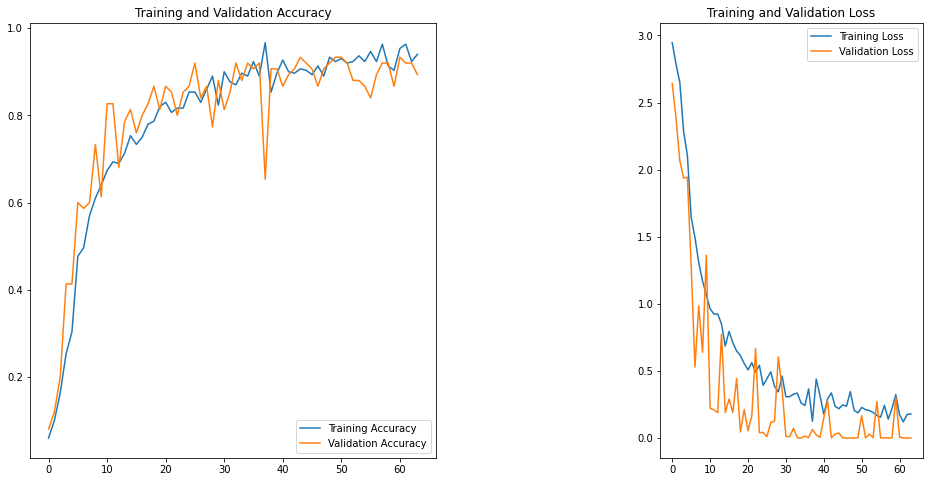

In [0]:
model_acc_val_plot(model2)

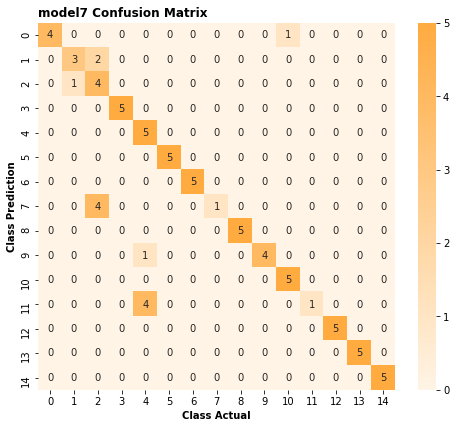

In [0]:
model_confusion(model2)

/content/drive/My Drive/RxID2/Data/Download
/content/drive/My Drive/RxID2


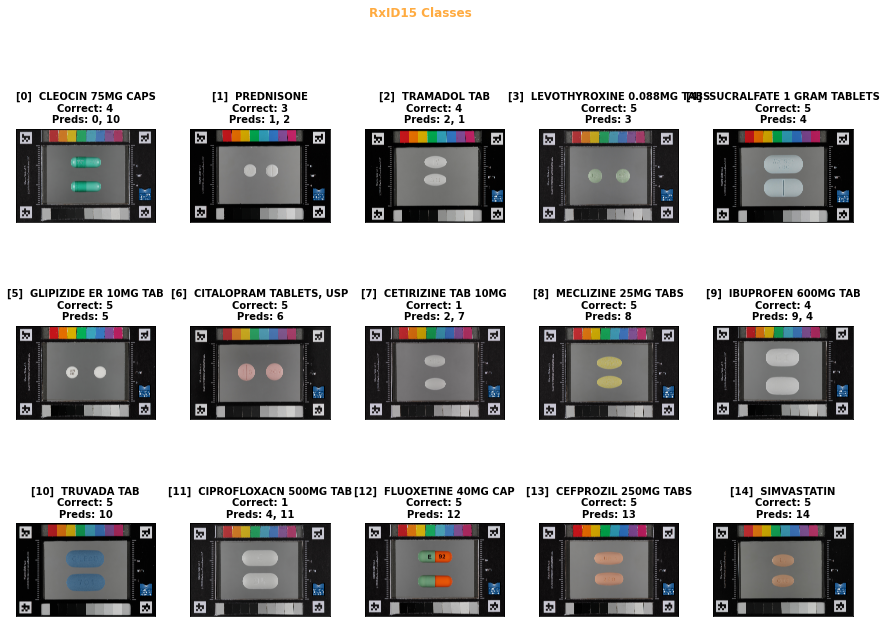

In [0]:
predict_plot(model2)